In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('../../data/processed/WESAD/feature_extracted/30s/data_EDA.csv', index_col=0)

In [3]:
data

,ACC_x_mean,ACC_y_mean,ACC_z_mean,net_acc_mean,net_acc_std,EDA_mean,EDA_std,EDA_slope,RESP_rate,RESP_regularity,HR,IBI,RMSSD,SDNN,pNN50,lf/hf,label,subject,focus_label
0,39.252000,-47.664667,7.822000,62.549339,0.544205,0.563131,0.014406,-0.000412,21.083279,1.630067,63.966173,958.669355,213.058396,133.561891,90.000000,5.933398,1,8,1
1,39.628667,-46.246667,9.764000,62.469299,1.120992,0.523506,0.009367,-0.000265,21.327375,1.591487,66.372243,911.132812,134.469912,80.095987,74.193548,44.207315,1,8,1
2,38.927333,-48.439333,6.083333,62.442314,0.428267,0.520051,0.018623,0.000048,22.168906,1.352590,78.588847,803.631757,159.088795,155.426060,58.333333,707.930928,1,8,1
3,38.919333,-47.006667,-0.914667,62.576766,1.166077,0.493109,0.007353,-0.000203,24.011434,1.809602,65.088073,940.020161,199.098718,134.709634,63.333333,6.149627,1,8,1
4,49.157333,-18.907333,31.472000,62.762208,1.500866,0.470519,0.010338,-0.000283,20.909046,1.358827,65.761617,924.316406,145.875330,94.891277,54.838710,1.541767,1,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,0.845365,0.507291,0.657285,63.853702,0.399321,1.666305,0.275064,0.015516,25.986362,1.367629,81.259585,702.675342,105.928556,105.790283,44.320448,2.745719,2,52,0
2516,0.434435,-1.180916,1.546109,63.618417,0.597926,1.472772,0.199376,0.001819,23.920840,1.499594,83.186403,760.707310,131.108393,150.341837,48.433075,2.231972,3,52,0
2517,-1.338693,-0.066946,-0.187012,62.642205,0.587866,1.720254,0.277256,-0.008247,25.926898,1.234510,86.921731,695.837617,113.899323,121.327145,43.060233,3.371828,2,52,0
2518,0.490648,0.200864,-0.174208,63.290337,0.617119,1.703250,0.292064,0.001821,25.927494,1.258146,84.885149,700.136589,103.613951,123.408556,42.884753,2.662518,2,52,0


In [4]:
data.columns

Index(['ACC_x_mean', 'ACC_y_mean', 'ACC_z_mean', 'net_acc_mean', 'net_acc_std',
       'EDA_mean', 'EDA_std', 'EDA_slope', 'RESP_rate', 'RESP_regularity',
       'HR', 'IBI', 'RMSSD', 'SDNN', 'pNN50', 'lf/hf', 'label', 'subject',
       'focus_label'],
      dtype='object')

In [5]:
subjects = data['subject'].unique()

In [6]:
def safe_slope(x):
    if len(x) < 2 or np.all(np.isnan(x)):
        return np.nan
    try:
        return np.polyfit(range(len(x)), x, 1)[0]
    except np.linalg.LinAlgError:
        return np.nan

def add_features_mean_based(df):
    df['hr_diff'] = df['HR'].diff()
    df['hr_center'] = df['HR'] - df['HR'].mean()
    df['hr_slope'] = df['HR'].rolling(window=3, min_periods=2).apply(safe_slope, raw=True)
    df['hr_zscore'] = (df['HR'] - df['HR'].mean()) / df['HR'].std()

    df['sdnn_diff'] = df['SDNN'].diff()
    df['sdnn_slope'] = df['SDNN'].rolling(window=3, min_periods=2).apply(safe_slope, raw=True)
    df['sdnn_zscore'] = (df['SDNN'] - df['SDNN'].mean()) / df['SDNN'].std()

    df['acc_ratio'] = df['net_acc_std'] / df['net_acc_mean']
    df['net_acc_mean_slope'] = df['net_acc_mean'].rolling(window=3, min_periods=2).apply(safe_slope, raw=True)
    df['net_acc_mean_diff'] = df['net_acc_mean'].diff()

    df['acc_vector_magnitude_mean'] = np.sqrt(
        df['ACC_x_mean']**2 + df['ACC_y_mean']**2 + df['ACC_z_mean']**2
    )
    df['acc_vector_slope'] = df['acc_vector_magnitude_mean'].rolling(window=3, min_periods=2).apply(safe_slope, raw=True)

    df['hr_netacc_interaction'] = df['HR'] * df['net_acc_mean']
    df['hr_sdnn_ratio'] = df['HR'] / (df['SDNN'] + 1e-6)
    df['acc_hr_slope_diff'] = df['net_acc_std'] - df['hr_slope']
    df['sdnn_netacc_ratio'] = df['SDNN'] / (df['net_acc_mean'] + 1e-6)

    df['eda_hr_interaction'] = df['EDA_mean'] * df['HR']
    df['eda_resp_ratio'] = df['EDA_std'] / df['RESP_regularity']
    df['hr_resp_interaction'] = df['HR'] * df['RESP_rate']
    df['hrv_composite'] = (df['RMSSD'] + df['SDNN'] + df['pNN50']) / 3
    df['hrv_stress_index'] = df['SDNN'] / df['RMSSD']

    df['arousal_index'] = df['HR'] * df['EDA_mean'] * df['RESP_rate']
 
    '''if 'subject' in df.columns:
        df['HR_baseline_sub'] = df['HR'] - df.groupby('subject')['HR'].transform('mean')
        df['SDNN_baseline_sub'] = df['SDNN'] - df.groupby('subject')['SDNN'].transform('mean')
        df['net_acc_mean_sub'] = df['net_acc_mean'] - df.groupby('subject')['net_acc_mean'].transform('mean')'''

    return df


In [7]:
data_feature_addon = []

In [8]:
for s in subjects:
    df = data[data['subject'] == s].copy().reset_index(drop=True)
    df = add_features_mean_based(df)
    df.dropna(inplace=True)
    data_feature_addon.append(df)

In [9]:
df_all = pd.concat(data_feature_addon, ignore_index=True)

In [10]:
df_all

,ACC_x_mean,ACC_y_mean,ACC_z_mean,net_acc_mean,net_acc_std,EDA_mean,EDA_std,EDA_slope,RESP_rate,RESP_regularity,...,hr_netacc_interaction,hr_sdnn_ratio,acc_hr_slope_diff,sdnn_netacc_ratio,eda_hr_interaction,eda_resp_ratio,hr_resp_interaction,hrv_composite,hrv_stress_index,arousal_index
0,39.628667,-46.246667,9.764000,62.469299,1.120992,0.523506,0.009367,-0.000265,21.327375,1.591487,...,4146.227502,0.828659,-1.285078,1.282166,34.746298,0.005886,1415.545722,96.253149,0.595642,741.047339
1,38.927333,-48.439333,6.083333,62.442314,0.428267,0.520051,0.018623,0.000048,22.168906,1.352590,...,4907.269442,0.505635,-6.883070,2.489114,40.870200,0.013768,1742.228749,124.282730,0.976977,906.047629
2,38.919333,-47.006667,-0.914667,62.576766,1.166077,0.493109,0.007353,-0.000203,24.011434,1.809602,...,4073.001086,0.483173,1.808162,2.152710,32.095491,0.004064,1562.857969,132.380562,0.676597,770.658757
3,49.157333,-18.907333,31.472000,62.762208,1.500866,0.470519,0.010338,-0.000283,20.909046,1.358827,...,4127.344249,0.693021,7.914481,1.511917,30.942103,0.007608,1375.012643,98.535106,0.650496,646.969837
4,46.228000,-39.174667,13.782000,62.674127,1.910619,0.442887,0.007276,-0.000196,22.165715,1.926374,...,4776.040885,0.500648,-3.647517,2.428616,33.749942,0.003777,1689.123832,116.329704,1.112837,748.091592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2465,0.845365,0.507291,0.657285,63.853702,0.399321,1.666305,0.275064,0.015516,25.986362,1.367629,...,5188.725366,0.768120,-4.148293,1.656760,135.403222,0.201125,2111.641014,85.346429,0.998695,3518.637163
2466,0.434435,-1.180916,1.546109,63.618417,0.597926,1.472772,0.199376,0.001819,23.920840,1.499594,...,5292.187298,0.553315,1.079783,2.363181,122.514646,0.132953,1989.888618,109.961102,1.146699,2930.653209
2467,-1.338693,-0.066946,-0.187012,62.642205,0.587866,1.720254,0.277256,-0.008247,25.926898,1.234510,...,5444.968872,0.716424,-2.243207,1.936827,149.527422,0.224588,2253.610882,92.762234,1.065214,3876.782269
2468,0.490648,0.200864,-0.174208,63.290337,0.617119,1.703250,0.292064,0.001821,25.927494,1.258146,...,5372.409678,0.687838,-0.232254,1.949880,144.580669,0.232138,2200.859165,89.969086,1.191042,3748.614392


In [11]:
df_all.to_csv('../../data/processed/WESAD/feature_extracted/30s/data_feature_engineered.csv')

In [12]:
df_all.columns

Index(['ACC_x_mean', 'ACC_y_mean', 'ACC_z_mean', 'net_acc_mean', 'net_acc_std',
       'EDA_mean', 'EDA_std', 'EDA_slope', 'RESP_rate', 'RESP_regularity',
       'HR', 'IBI', 'RMSSD', 'SDNN', 'pNN50', 'lf/hf', 'label', 'subject',
       'focus_label', 'hr_diff', 'hr_center', 'hr_slope', 'hr_zscore',
       'sdnn_diff', 'sdnn_slope', 'sdnn_zscore', 'acc_ratio',
       'net_acc_mean_slope', 'net_acc_mean_diff', 'acc_vector_magnitude_mean',
       'acc_vector_slope', 'hr_netacc_interaction', 'hr_sdnn_ratio',
       'acc_hr_slope_diff', 'sdnn_netacc_ratio', 'eda_hr_interaction',
       'eda_resp_ratio', 'hr_resp_interaction', 'hrv_composite',
       'hrv_stress_index', 'arousal_index'],
      dtype='object')

In [13]:
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
X = df_all.drop(columns=['label', 'subject', 'focus_label'])
y = df_all.focus_label

In [15]:
model = RandomForestClassifier()

In [16]:
model.fit(X, y)

RandomForestClassifier()

In [17]:
importances = model.feature_importances_
features = X.columns
sorted_idx = np.argsort(importances)[::-1]

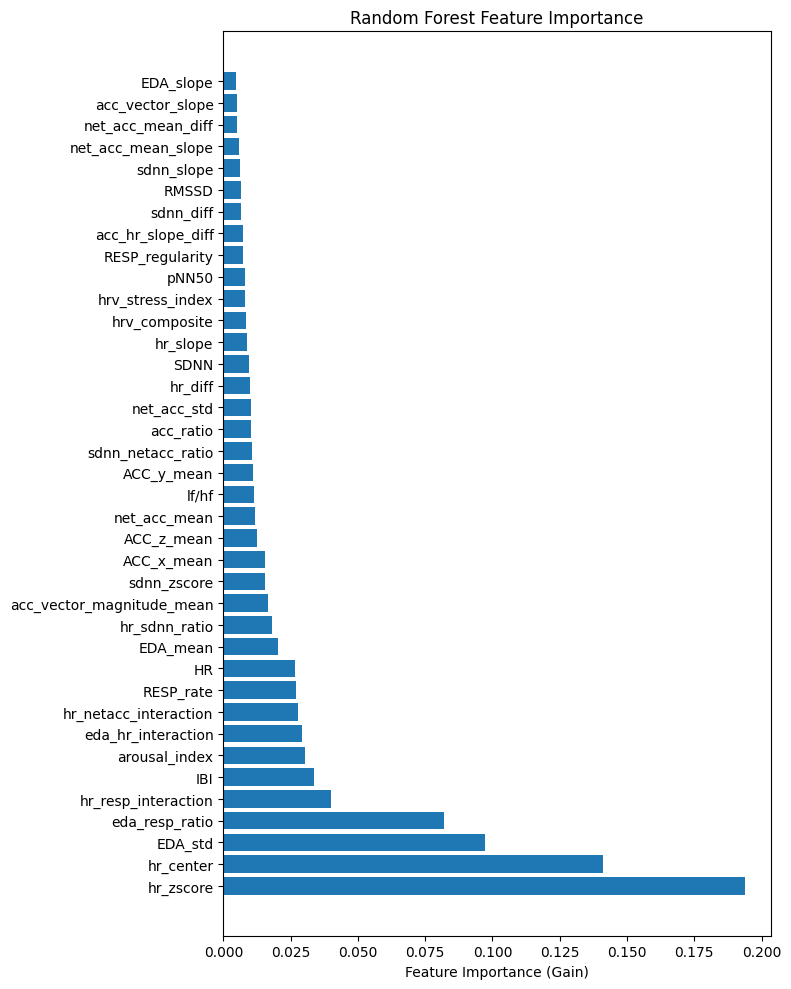

In [18]:
plt.figure(figsize=(8, 10))
plt.barh(features[sorted_idx], importances[sorted_idx])
plt.xlabel("Feature Importance (Gain)")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

In [19]:
top_15_feature = features[sorted_idx[:15]].tolist()

In [20]:
print(top_15_feature)

['hr_zscore', 'hr_center', 'EDA_std', 'eda_resp_ratio', 'hr_resp_interaction', 'IBI', 'arousal_index', 'eda_hr_interaction', 'hr_netacc_interaction', 'RESP_rate', 'HR', 'EDA_mean', 'hr_sdnn_ratio', 'acc_vector_magnitude_mean', 'sdnn_zscore']
